In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Couple of Improvements

Before moving further, let's introduce a couple of improvements that will simplify the syntax and provide additional insights during the training process.

#### 1. **Simplified Syntax Using `nn.Sequential`**

Our original model definition:


In [2]:
# 2. Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

   The following code refactor uses **`nn.Sequential`** to define the model in a more compact and readable way. This allows us to stack layers sequentially without having to explicitly define each layer in the class constructor. Here's how the model looks now:

In [3]:
# Simplified syntax to define the same model using nn.Sequential
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Flatten the tensor (from 64x8x8 to 4096)
            nn.Flatten(),
            
            # Fully connected layers
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)  # Output layer for 10 classes (CIFAR-10)
        )

    def forward(self, x):
        return self.model(x)

### Step-by-Step Explanation:

1. **Layer Definition**: 
   - In the simplified version, all layers are defined inside **`nn.Sequential`**, which automatically handles the forward pass. In the original version, each layer is defined as an individual attribute (e.g., `self.conv1`, `self.fc1`), and the forward pass applies them manually.
   
2. **Flattening**: 
   - The **`nn.Flatten()`** layer is used in the simplified version to automatically flatten the tensor, whereas in the original, `x.view(-1, 64 * 8 * 8)` is used explicitly.

3. **Forward Pass**: 
   - In the simplified version, the entire forward pass is done in one line by calling `self.model(x)`. In the original, each layer is applied step by step.

### **`super().__init__()` vs `super(SimpleCNN, self).__init__()`**
- **`super().__init__()`**: A modern and concise way to call the parent class's `__init__` method. It automatically handles class and instance, simplifying the code.
- **`super(SimpleCNN, self).__init__()`**: The older style, explicitly specifying the class and instance. It works but is more verbose.

### When to Use:
- **`nn.Sequential`**: For simple models with a straightforward flow of layers.
- **Explicit Layer Definitions**: For more complex models requiring conditional operations or custom layer behavior.

In [4]:
# 1. Load and Transform Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Files already downloaded and verified


#### 2. **Tracking and Plotting Losses and Accuracy**:

We also need **Real-Time Monitoring** of the training process with a progress bar, loss, and accuracy plots to help track model performance throughout training. The values are plotted after every `plot_interval`. Basically this is a combination of training and evalution loops (**Step 3: Train the CNN** and **Step 4: Evaluate Model**) with plotting functionality.

  0%|          | 0/10 [00:00<?, ?it/s]

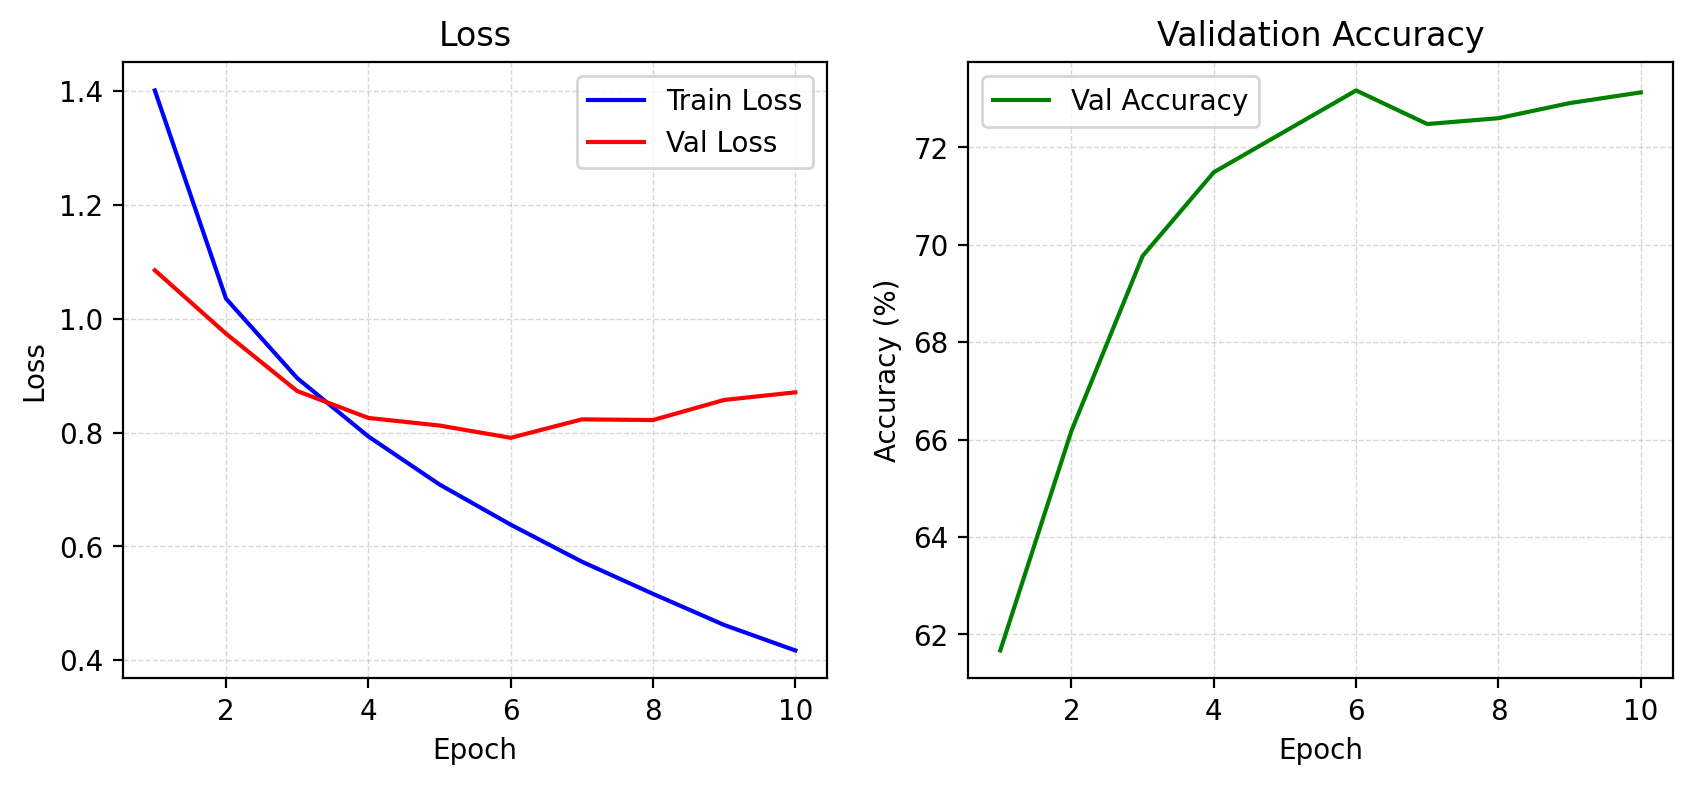

Epoch 10/10: 100%|##########| 10/10 [04:08<00:00, 24.14s/it, Train Loss: 0.4172, Val Loss: 0.8708, Val Acc: 73…

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.4014       |       1.0854       |         61.6700         |
|         2          |       1.0355       |       0.9740       |         66.1800         |
|         3          |       0.8959       |       0.8731       |         69.7700         |
|         4          |       0.7933       |       0.8258       |         71.4900         |
|         5          |       0.7089       |       0.8125       |         72.3300         |
|         6          |       0.6383       |       0.7909       |         73.1700         |
|         7          |       0.5733       |       0.8233       |         72.4800         |
|         8          |       0.5167       |       0.8221       |         72.6000         |
|         9          |       0.4620       |       0.8574       |         72.9100         |

In [ ]:
from IPython.display import display
from tqdm.auto import tqdm
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# Step 3:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
plot_interval = 1
train_losses = []
val_losses = []
val_accuracies = []


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
pbar = tqdm(total=num_epochs, leave=True)

hdisplay_img = display(display_id=True)
hdisplay_pbar = display(display_id=True)
title = f"|{'Epoch':^20}|{'Train loss':^20}|{'Validation loss':^20}|{'Validation accuracy, %':^25}|"
print(title)
print("_"*len(title))

for epoch in range(num_epochs):
    # Step 3
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    
    # Step 4
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(testloader)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    # tqdm progress bar
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
    pbar.set_postfix_str(f"Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")
    pbar.update()
    
    # Plotting updates every `plot_interval` epochs
    if (epoch + 1) % plot_interval == 0:        
        # Clear the previous plots
        ax1.clear()
        ax2.clear()
        
        # Plot training and validation loss
        ax1.plot(range(1, epoch + 2), train_losses, 'b-', label='Train Loss')
        ax1.plot(range(1, epoch + 2), val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss')
        ax1.legend()
        ax1.grid(linestyle="--", linewidth=0.5, alpha=0.5)

        # Plot validation accuracy
        ax2.plot(range(1, epoch + 2), val_accuracies, 'g-', label='Val Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Validation Accuracy')
        ax2.legend()
        ax2.grid(linestyle="--", linewidth=0.5, alpha=0.5)
        hdisplay_img.update(fig)
        hdisplay_pbar.update(pbar.container)

    print(f"|{epoch+1:^20}|{train_loss:^20.4f}|{avg_val_loss:^20.4f}|{accuracy:^25.4f}|")
plt.close()

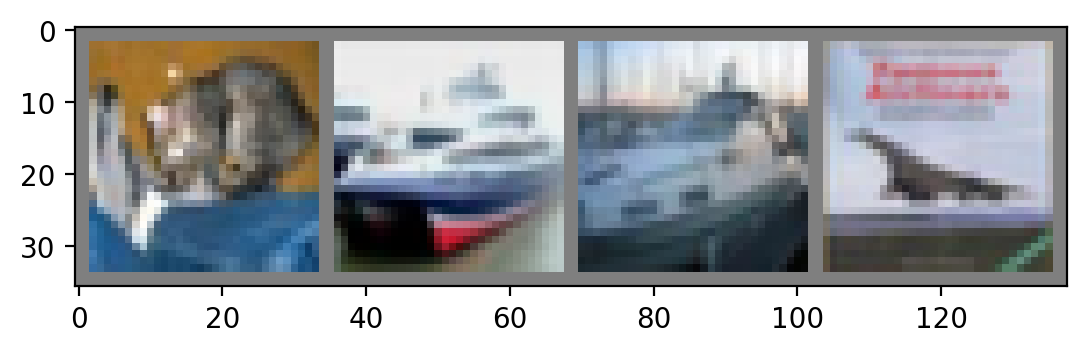

GroundTruth: cat ship ship plane
Predicted: cat car ship plane


In [6]:
import numpy as np
# 5. Visualize Predictions
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(4)))

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(classes[predicted[j]] for j in range(4)))

### Exercise 1. **Find Steps 3 and 4 of the Previous Notebook**  
Read through the code and identify **Step 3: Train the CNN** and **Step 4: Evaluate the Model** as presented in the previous notebook. Compare how these steps are implemented in the current code. Are there any noticeable differences? Focus on the flow of the training and evaluation processes, how the losses and accuracies are computed, and how the updates are managed.

As we will reuse this piece of code many times, so let's wraped it into a function to handle the plotting and monitoring of the training process. This will make the code cleaner and more modular:

In [7]:
def training_monitor(device, model, optimizer, criterion, num_epochs, 
                     trainloader=trainloader, 
                     testloader=testloader,
                     plot_interval = 1):
    
    train_losses = []
    val_losses = []
    val_accuracies = []


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    pbar = tqdm(total=num_epochs, leave=True)

    hdisplay_img = display(display_id=True)
    hdisplay_pbar = display(display_id=True)
    title = f"|{'Epoch':^20}|{'Train loss':^20}|{'Validation loss':^20}|{'Validation accuracy, %':^25}|"
    print(title)
    print("_"*len(title))

    for epoch in range(num_epochs):
        # Step 3
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        
        # Step 4
        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(testloader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        
        # tqdm progress bar
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        pbar.set_postfix_str(f"Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")
        pbar.update()
        
        # Plotting updates every `plot_interval` epochs
        if (epoch + 1) % plot_interval == 0:        
            # Clear the previous plots
            ax1.clear()
            ax2.clear()
            
            # Plot training and validation loss
            ax1.plot(range(1, epoch + 2), train_losses, 'b-', label='Train Loss')
            ax1.plot(range(1, epoch + 2), val_losses, 'r-', label='Val Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.set_title('Loss')
            ax1.legend()
            ax1.grid(linestyle="--", linewidth=0.5, alpha=0.5)

            # Plot validation accuracy
            ax2.plot(range(1, epoch + 2), val_accuracies, 'g-', label='Val Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy (%)')
            ax2.set_title('Validation Accuracy')
            ax2.legend()
            ax2.grid(linestyle="--", linewidth=0.5, alpha=0.5)
            hdisplay_img.update(fig)
            hdisplay_pbar.update(pbar.container)

        print(f"|{epoch+1:^20}|{train_loss:^20.4f}|{avg_val_loss:^20.4f}|{accuracy:^25.4f}|")
    plt.close()
    return model

Now we can train like this:

  0%|          | 0/10 [00:00<?, ?it/s]

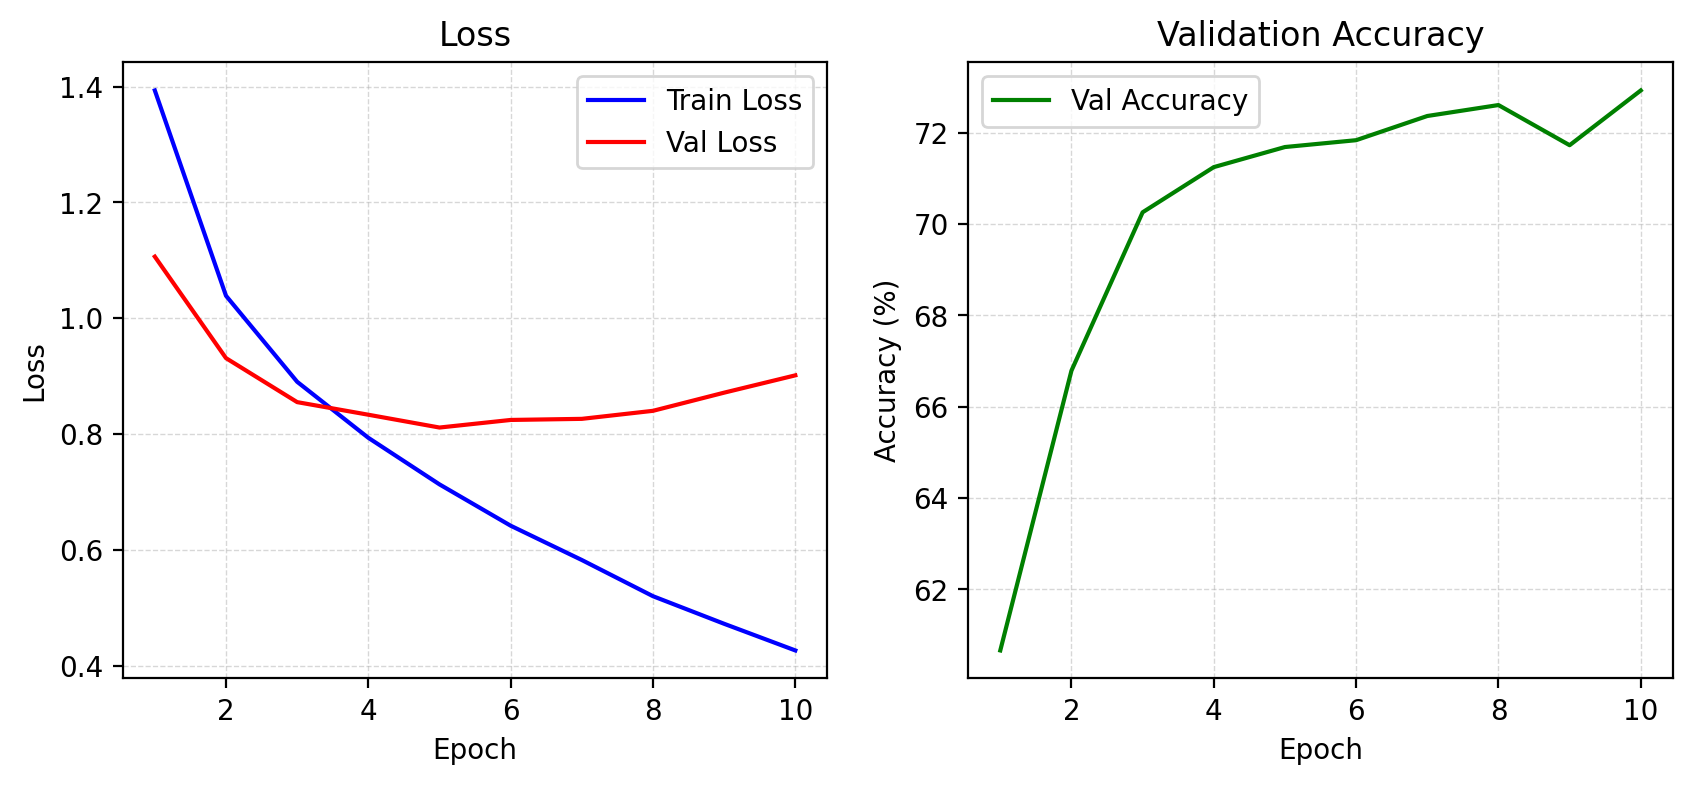

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.3935       |       1.1064       |         60.6600         |
|         2          |       1.0388       |       0.9311       |         66.7900         |
|         3          |       0.8902       |       0.8551       |         70.2600         |
|         4          |       0.7935       |       0.8334       |         71.2500         |
|         5          |       0.7130       |       0.8112       |         71.6900         |
|         6          |       0.6417       |       0.8243       |         71.8400         |
|         7          |       0.5824       |       0.8262       |         72.3700         |
|         8          |       0.5199       |       0.8401       |         72.6100         |
|         9          |       0.4722       |       0.8715       |         71.7300         |

|         3          |       0.8745       |       0.8457       |         70.3100         |
|         4          |       0.7733       |       0.8593       |         70.0800         |
|         5          |       0.6923       |       0.8871       |         69.7200         |
|         6          |       0.6212       |       0.7994       |         72.9000         |
|         7          |       0.5575       |       0.7997       |         73.5400         |
|         8          |       0.5017       |       0.8047       |         73.8200         |
|         9          |       0.4466       |       0.8343       |         73.2300         |
|         10         |       0.4057       |       0.8762       |         72.8600         |


In [8]:
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs)

### Exercise 2. **Increase the Number of Epochs and Observe Behavior**  
Modify the `num_epochs` value to be greater than 10 (e.g., try 20, 50, or even 100 epochs). Run the model and monitor how the **training loss**, **validation loss**, and **validation accuracy** behave across the increased number of epochs. Pay attention to whether the model continues improving, starts to overfit, or stabilizes after a certain number of epochs.

### Exercise 3. **Change Learning Rate to Higher Values and Observe Behavior**  
Experiment by changing the learning rate of the optimizer to a larger value (e.g., try `lr=0.01` or `lr=0.1`). Run the training again and observe how the **training loss** and **validation loss** behave. Does the model converge faster? Does it start diverging or oscillating? Keep track of how the model's performance is affected by this change in the learning rate and visualize the results using the loss and accuracy plots.

### Exercise 4. **Change Device to CPU and Observe Training Time**  
Change the device from GPU to CPU by modifying the following line:
```python
device = torch.device("cpu")
```
Run the model again on the CPU and compare the training time to when it was run on a GPU. How much longer does the training take when using the CPU? Monitor the time per epoch and evaluate whether training on the CPU is significantly slower than on the GPU.